In [1]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-10-03 13:02:03--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.207, 64.233.181.207, 173.194.193.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   142MB/s    in 0.6s    

2023-10-03 13:02:04 (142 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [3]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

In [4]:
# Choose `mixed7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [5]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

In [7]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])


In [9]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2023-10-03 13:15:55--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.6.207, 172.217.212.207, 74.125.124.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.6.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   208MB/s    in 0.3s    

2023-10-03 13:15:56 (208 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [10]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Extract the archive
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

# Define our example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary',
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 197s - loss: 0.3369 - accuracy: 0.8590 - val_loss: 0.0948 - val_accuracy: 0.9600 - 197s/epoch - 2s/step
Epoch 2/20
100/100 - 188s - loss: 0.2147 - accuracy: 0.9140 - val_loss: 0.1165 - val_accuracy: 0.9540 - 188s/epoch - 2s/step
Epoch 3/20
100/100 - 187s - loss: 0.1771 - accuracy: 0.9270 - val_loss: 0.0868 - val_accuracy: 0.9750 - 187s/epoch - 2s/step
Epoch 4/20
100/100 - 187s - loss: 0.1648 - accuracy: 0.9315 - val_loss: 0.1012 - val_accuracy: 0.9640 - 187s/epoch - 2s/step
Epoch 5/20
100/100 - 187s - loss: 0.1678 - accuracy: 0.9345 - val_loss: 0.0956 - val_accuracy: 0.9620 - 187s/epoch - 2s/step
Epoch 6/20
100/100 - 229s - loss: 0.1479 - accuracy: 0.9410 - val_loss: 0.1007 - val_accuracy: 0.9650 - 229s/epoch - 2s/step
Epoch 7/20
100/100 - 227s - loss: 0.1457 - accuracy: 0.9450 - val_loss: 0.1044 - val_accuracy: 0.9660 - 227s/epoch - 2s/step
Epoch 8/20
100/100 - 198s - loss: 0.1563 - accuracy: 0.9390 - val_loss: 0.0904 - val_accuracy: 0.9660 - 198s/epoch - 2s/step


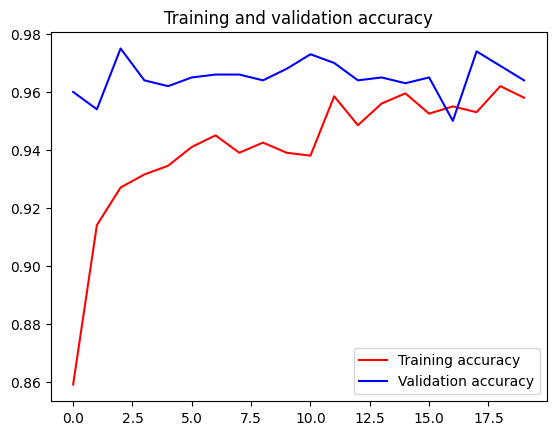

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()